In [1]:
%env CUDA_VISIBLE_DEVICES=6

import torch
import math

from bitsandbytes.functional import (
    quantize_fp4, quantize_nf4, quantize_blockwise,
    dequantize_fp4, dequantize_nf4, dequantize_blockwise,
)

from gptq.edenn import higgs_quantize_dequantize

from tqdm.auto import trange, tqdm

env: CUDA_VISIBLE_DEVICES=6


In [2]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B", torch_dtype="auto", device_map="cpu")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
weight = model.model.layers[0].self_attn.q_proj.weight.data.cuda().clone().detach()

(0.0, 1.049983226868605)

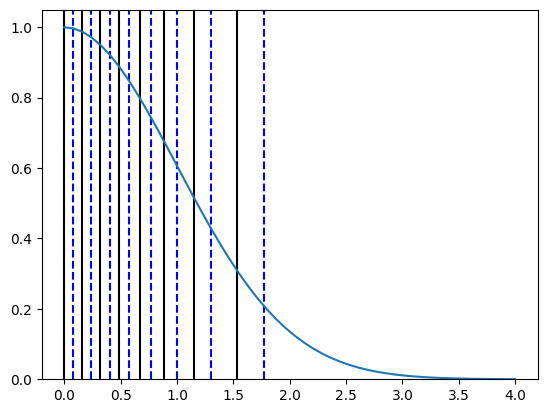

In [4]:
from scipy.stats import norm

nf4_boundaries = norm.ppf(torch.linspace(0.5, 1 - 1/16, 8)).tolist()

nf4_centers = [nf4_boundaries[1] / 2]
for i in range(len(nf4_boundaries) - 1):
    nf4_centers.append(2 * nf4_boundaries[i + 1] - nf4_centers[i])

import matplotlib.pyplot as plt
import numpy as np

for b in nf4_boundaries:
    plt.axvline(b, color="black")
    
for c in nf4_centers:
    plt.axvline(c, color="blue", linestyle="--")
    
plt.plot(np.linspace(0, 4), np.exp(-np.linspace(0, 4)**2/2))

plt.ylim(0, None)

(0.0, 16671.2)

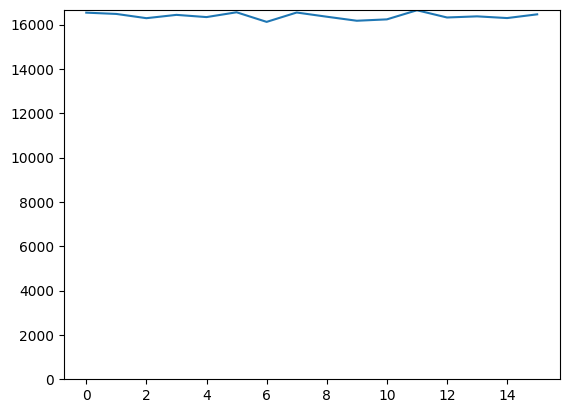

In [5]:
NF4_GRID = torch.asarray(nf4_centers)[:, None].float().cuda()
NF4_GRID = torch.cat((-torch.flip(NF4_GRID, dims=(0,)), NF4_GRID), dim=0)

x = torch.randn((2**18,), device="cuda")

ids = torch.argmax(2 * x[..., None] @ NF4_GRID.T - torch.linalg.norm(NF4_GRID, dim=1) ** 2, -1)

_, counts = torch.unique(ids, return_counts=True)

plt.plot(np.arange(16), counts.cpu().numpy())
plt.ylim(0, None)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.0, 1.0464905066018133)

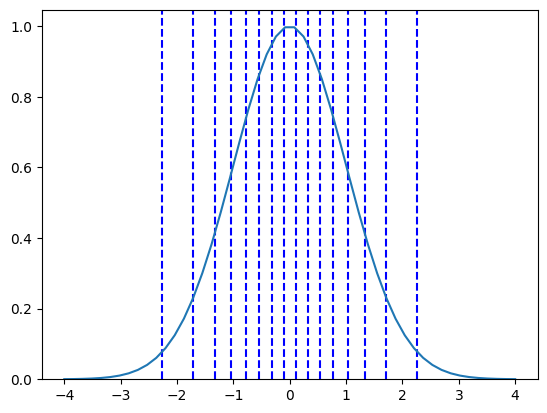

In [6]:
af_4_centers = np.linspace(-1, 1, num=16, endpoint=True)


for i in trange(1000):
    af_4_boundaries_quantiles = [0.0] + [norm.cdf((af_4_centers[i] + af_4_centers[i + 1]) / 2) for i in range(len(af_4_centers) - 1)] + [1.0]
    af_4_centers = [norm.ppf((af_4_boundaries_quantiles[i] + af_4_boundaries_quantiles[i + 1]) / 2) for i in range(len(af_4_boundaries_quantiles) - 1)]
    
    
import matplotlib.pyplot as plt
import numpy as np

for c in af_4_centers:
    plt.axvline(c, color="blue", linestyle="--")
    
plt.plot(np.linspace(-4, 4), np.exp(-np.linspace(-4, 4)**2/2))

plt.ylim(0, None)

In [7]:
AF4_GRID = torch.asarray(af_4_centers)[:, None].float().cuda()

In [8]:
def entropy(idx):
    _, counts = torch.unique(idx, return_counts=True)
    counts = counts.to(torch.float)
    return -torch.sum(counts / idx.numel() * torch.log2(counts / idx.numel())).item()

@torch.no_grad()
def higgs_grouped_quantize_dequantize(weight, d, n, group_size=1024):
    weight = weight.clone().detach().reshape(weight.shape[0], -1, group_size).float()
    scales = torch.norm(weight, dim=-1)[..., None] / math.sqrt(group_size)
    weight = weight / scales
    
    orig_shape = weight.shape
    
    for i in range(0, weight.shape[0], 1024):
        q, codes_entropy = higgs_quantize_dequantize(weight[i:i+1024].reshape(-1, d), d, n)
        weight[i:i+1024] = q.reshape(weight[i:i+1024].shape)
    
    weight = weight.reshape(orig_shape)

    return (weight * scales).reshape(weight.shape[0], -1), codes_entropy / d


def create_nf4_grid(offset=0.9677083, symmetric=True):
    from scipy.stats import norm
    
    if symmetric:
        v = norm.ppf(torch.linspace(1/17, 1, 16)[:-1]).tolist()
    else:
        # one more positive value, this is an asymmetric type
        v1 = norm.ppf(torch.linspace(offset, 0.5, 9)[:-1]).tolist()
        v3 = (-norm.ppf(torch.linspace(offset, 0.5, 8)[:-1])).tolist()
        v = v1 + v3

    values = torch.Tensor(v)
    values = values.sort().values

    return values[:,None]

ASYMMETRIC_NF4_GRID = create_nf4_grid(symmetric=False).cuda()

@torch.no_grad()
def custom_grouped_quantize_dequantize(weight, grid, group_size=1024):
    weight = weight.clone().detach().reshape(weight.shape[0], -1, group_size).float()
    scales = torch.norm(weight, dim=-1)[..., None] / math.sqrt(group_size)
    weight = weight / scales
    
    orig_shape = weight.shape
    
    ids = torch.argmax(2 * weight[..., None] @ grid.T - torch.linalg.norm(grid, dim=1) ** 2, -1)
    codes_entropy = entropy(ids)
    weight = grid[ids]
    
    weight = weight.reshape(orig_shape)

    return (weight * scales).reshape(weight.shape[0], -1), codes_entropy

In [9]:
def bnb_nf4(w):
    codes, state = quantize_nf4(w)
    return dequantize_nf4(codes, state), entropy(torch.cat((codes // 16, codes % 16)))

def bnb_int8(w):
    codes, state = quantize_blockwise(w)
    return dequantize_blockwise(codes, state), entropy(codes)

In [10]:
grids = [
    {"name": "Symmetric nf4", "qdq": lambda w: custom_grouped_quantize_dequantize(w, NF4_GRID)},
    {"name": "Asymmetric nf4", "qdq": lambda w: custom_grouped_quantize_dequantize(w, ASYMMETRIC_NF4_GRID)},
    {"name": "af4", "qdq": lambda w: custom_grouped_quantize_dequantize(w, AF4_GRID)},
    {"name": "EDEN", "qdq": lambda w: higgs_grouped_quantize_dequantize(w, 1, 2**4)},
    {"name": "HIGGS", "qdq": lambda w: higgs_grouped_quantize_dequantize(w, 2, 2**8)},
    {"name": "BnB nf4", "qdq": lambda w: bnb_nf4(w)},
    {"name": "BnB int8", "qdq": lambda w: bnb_int8(w)},
]

In [11]:
print("No Hadamard")

for grid in grids:
    qdq_weight, codes_entropy = grid["qdq"](weight)
    grid["rmse"] = (qdq_weight - weight).pow(2).sum() / weight.pow(2).sum()
    grid["l1_err"] = (qdq_weight - weight).abs().sum() / weight.abs().sum()
    grid["entropy"] = codes_entropy
    print(f"{grid['name']:<16}:    l2: {grid['rmse']:<8.4f} l1: {grid['l1_err']:<8.4f} ent: {codes_entropy:<8.2f}")

No Hadamard
Symmetric nf4   :    l2: 0.1299   l1: 0.2020   ent: 3.59    
Asymmetric nf4  :    l2: 0.1242   l1: 0.2384   ent: 3.39    
af4             :    l2: 0.0779   l1: 0.1755   ent: 3.48    
EDEN            :    l2: 0.0502   l1: 0.1445   ent: 3.19    
HIGGS           :    l2: 0.0354   l1: 0.1350   ent: 3.40    
BnB nf4         :    l2: 0.0103   l1: 0.1235   ent: 3.12    
BnB int8        :    l2: 0.0002   l1: 0.0151   ent: 7.33    


In [12]:
import math

from fast_hadamard_transform import hadamard_transform

h_weight = hadamard_transform(weight, scale=1/math.sqrt(weight.shape[-1]))

print("With Hadamard")

for grid in grids:
    qdq_h_weight, codes_entropy = grid["qdq"](h_weight)
    grid["h_rmse"] = (qdq_h_weight - h_weight).pow(2).sum() / h_weight.pow(2).sum()
    grid["h_l1_err"] = (qdq_h_weight - h_weight).abs().sum() / h_weight.abs().sum()
    grid["h_entropy"] = codes_entropy
    print(f"{grid['name']:<16}:    l2: {grid['h_rmse']:<8.4f} l1: {grid['h_l1_err']:<8.4f} ent: {codes_entropy:<8.2f}")

With Hadamard
Symmetric nf4   :    l2: 0.0269   l1: 0.1057   ent: 4.00    
Asymmetric nf4  :    l2: 0.0243   l1: 0.1097   ent: 3.89    
af4             :    l2: 0.0116   l1: 0.0930   ent: 3.91    
EDEN            :    l2: 0.0096   l1: 0.0984   ent: 3.76    
HIGGS           :    l2: 0.0078   l1: 0.0873   ent: 3.90    
BnB nf4         :    l2: 0.0084   l1: 0.0908   ent: 3.89    
BnB int8        :    l2: 0.0002   l1: 0.0125   ent: 7.07    


In [13]:
@torch.no_grad()
def llama_eval(model, dataloader, dev):
    print('Evaluating ...')

    nsamples = len(dataloader) 

    use_cache = model.config.use_cache
    model.config.use_cache = False
    layers = model.model.layers

    model.model.embed_tokens = model.model.embed_tokens.to(dev)
    model.model.rotary_emb = model.model.rotary_emb.to(dev)
    layers[0] = layers[0].to(dev)

    dtype = next(iter(model.parameters())).dtype
    inps = []
    attention_masks = []
    position_ids = []

    class Catcher(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, inp, **kwargs):
            inps.append(inp)
            attention_masks.append(kwargs['attention_mask'])
            position_ids.append(kwargs['position_ids'])
            raise ValueError
    layers[0] = Catcher(layers[0])
    for batch in dataloader:
        try:
            model(batch.to(dev))
        except ValueError:
            pass
    layers[0] = layers[0].module

    layers[0] = layers[0].cpu()
    model.model.embed_tokens = model.model.embed_tokens.cpu()
    torch.cuda.empty_cache()

    for i in trange(len(layers), desc=f"Evaluating layer-by-layer..."):
        layer = layers[i].to(dev)
        for j in range(nsamples):
            inps[j] = layer(inps[j], attention_mask=attention_masks[j], position_ids=position_ids[j])[0]
        layers[i] = layer.cpu()
        del layer
        torch.cuda.empty_cache()

    if model.model.norm is not None:
        model.model.norm = model.model.norm.to(dev)
    model.lm_head = model.lm_head.to(dev)

    nlls = []
    for i in range(nsamples):
        hidden_states = inps[i]
        if model.model.norm is not None:
            hidden_states = model.model.norm(hidden_states)
        lm_logits = model.lm_head(hidden_states)
        shift_logits = lm_logits[:, :-1, :].contiguous()
        shift_labels = (dataloader[i].to(dev))[:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * model.seqlen
        nlls.append(neg_log_likelihood)
    ppl = torch.exp(torch.stack(nlls).sum() / (nsamples * model.seqlen))
    print(ppl.item())

    model.config.use_cache = use_cache
    
    return ppl.item()

In [14]:
from torch import nn

from gptq.edenn import pad_to_block, HadLinear

def find_layers(module, layers=[nn.Linear], name=''):
    if type(module) in layers:
        return {name: module}
    res = {}
    for name1, child in module.named_children():
        res.update(find_layers(
            child, layers=layers, name=name + '.' + name1 if name != '' else name1
        ))
    return res


def replace_submodule(module, submodule_path, new_submodule):
    submodule_names = submodule_path.split(".")
    for submodule in submodule_names[:-1]:
        module = getattr(module, submodule)
    setattr(module, submodule_names[-1], new_submodule)
    
def replace_empty(model: nn.Module, had_block_size: int):
    linear_layers = find_layers(model)
    for name, layer in tqdm(linear_layers.items(), desc="Replacing linear layers..."):
        if "lm_head" in name:
            continue
        
        replace_submodule(model, name, HadLinear(pad_to_block(layer.weight, [1], had_block_size)))
    

@torch.no_grad()
def llama_rtn(model, hadamard_groupsize, device, qdq):
    linear_layers = find_layers(model)
    
    for (name, layer) in tqdm(linear_layers.items(), desc="Quantizing linear layers..."):
        if "lm_head" in name:
            continue
        
        weight = layer.weight.data.to(device)
        if hadamard_groupsize != 0:
            weight = pad_to_block(weight, [-1], hadamard_groupsize).reshape(weight.shape[0], -1, hadamard_groupsize)
            weight = hadamard_transform(weight).reshape(weight.shape[0], -1)
            
        quantized_weight, _ = qdq(weight)
        quantized_weight = quantized_weight.half()
        
        if hadamard_groupsize == 0:
            layer.weight.data = quantized_weight
            layer.cpu()
        else:
            replace_submodule(model, name, HadLinear(quantized_weight, hadamard_groupsize).cpu())
        
    return model

In [16]:
from gptq.datautils import *

for grid in grids:
    model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B", torch_dtype=torch.float16, device_map="cpu")
    model.seqlen = 8192
    model = llama_rtn(model, 1024, "cuda", grid["qdq"])
    
    datasets = ['wikitext2'] 
    for dataset in datasets:
        dataloader, testloader = get_loaders(
            dataset, seed=0, model="meta-llama/Meta-Llama-3.1-8B", seqlen=8192
        )
        ppl = llama_eval(model, testloader, "cuda")
        grid[f"h_ppl_{dataset}"] = ppl

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.45 `position_ids` will be removed and `position_embeddings` will be mandatory.


5.614557266235352


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

6.026398658752441


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

6.038349151611328


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

6.134123802185059


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

6.26768684387207


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

7.424188137054443


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

7.96543550491333


In [15]:
print("With Hadamard")

for grid in grids:
    print(f"{grid['name']:<16}:    l2: {grid['h_rmse']:<8.4f} l1: {grid['h_l1_err']:<8.4f} entropy: {grid['h_entropy']:<8.2f} ppl : {grid['h_ppl_wikitext2'] if 'h_ppl_wikitext2' in grid else 0.0:<8.2f}")

With Hadamard
Symmetric nf4   :    l2: 0.0269   l1: 0.1057   entropy: 4.00     ppl : 0.00    
Asymmetric nf4  :    l2: 0.0243   l1: 0.1097   entropy: 3.89     ppl : 0.00    
af4             :    l2: 0.0116   l1: 0.0930   entropy: 3.91     ppl : 0.00    
EDEN            :    l2: 0.0096   l1: 0.0984   entropy: 3.76     ppl : 0.00    
HIGGS           :    l2: 0.0078   l1: 0.0873   entropy: 3.90     ppl : 0.00    
BnB nf4         :    l2: 0.0084   l1: 0.0908   entropy: 3.89     ppl : 0.00    
BnB int8        :    l2: 0.0002   l1: 0.0125   entropy: 7.07     ppl : 0.00    


In [17]:
from gptq.datautils import *

for grid in grids:
    model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B", torch_dtype=torch.float16, device_map="cpu")
    model.seqlen = 8192
    model = llama_rtn(model, 0, "cuda", grid["qdq"])
    
    datasets = ['wikitext2'] 
    for dataset in datasets:
        dataloader, testloader = get_loaders(
            dataset, seed=0, model="meta-llama/Meta-Llama-3.1-8B", seqlen=8192
        )
        ppl = llama_eval(model, testloader, "cuda")
        grid[f"ppl_{dataset}"] = ppl

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.45 `position_ids` will be removed and `position_embeddings` will be mandatory.


126668.734375


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

120437.234375


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

45651.6484375


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2436214 > 131072). Running this sequence through the model will result in indexing errors


Evaluating ...


Evaluating layer-by-layer...:   0%|          | 0/32 [00:00<?, ?it/s]

109537.0625


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.00 GiB. GPU 0 has a total capacity of 23.69 GiB of which 2.67 GiB is free. Process 783392 has 11.70 GiB memory in use. Including non-PyTorch memory, this process has 9.32 GiB memory in use. Of the allocated memory 7.58 GiB is allocated by PyTorch, and 620.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [22]:
print("No Hadamard")

for grid in grids:
    print(f"{grid['name']:<16}:    l2: {grid['rmse']:<8.4f} l1: {grid['l1_err']:<8.4f} entropy: {grid['entropy']:<8.2f} ppl : {grid['ppl_wikitext2'] if 'ppl_wikitext2' in grid else 0.0:<8.2f}")

No Hadamard
Symmetric nf4   :    l2: 0.1299   l1: 0.2020   entropy: 3.59     ppl : 126725.27
Asymmetric nf4  :    l2: 0.1242   l1: 0.2384   entropy: 3.39     ppl : 120437.23
af4             :    l2: 0.0779   l1: 0.1755   entropy: 3.48     ppl : 45661.84
EDEN            :    l2: 0.0502   l1: 0.1445   entropy: 3.19     ppl : 109463.76
HIGGS           :    l2: 0.0354   l1: 0.1350   entropy: 3.40     ppl : 42192.58
BnB nf4         :    l2: 0.0103   l1: 0.1235   entropy: 3.12     ppl : 5.96    
BnB int8        :    l2: 0.0002   l1: 0.0151   entropy: 7.33     ppl : 5.61    
